**Mount from Google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import zipfile
import os

# Define the zip file and extraction path
zip_file_path = '/content/drive/My Drive/preprocessed.zip'
extract_folder = '/content/dataset/preprocessed'

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Check the contents of the extracted folder
extracted_files = os.listdir(extract_folder)
print("Extracted files and folders:", extracted_files)

Mounted at /content/drive
Extracted files and folders: ['valid', 'train']


**Train Test Split**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to the dataset
train_dir = '/content/dataset/preprocessed/train'  # Replace with the path to your train folder

# Data augmentation and normalization for the training set (with a validation split)
train_datagen = ImageDataGenerator(
    rescale=1.0/255,   # Normalize pixel values (0-255 to 0-1)
    rotation_range=40,  # Rotate images by up to 40 degrees
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Allocate 20% of data for validation
)

# Create train and validation generators from the same folder
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize all images to 224x224 pixels
    batch_size=32,
    class_mode='categorical',  # For multi-class classification
    subset='training'  # Use 80% of the data for training
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Use 20% of the data for validation
)

Found 56251 images belonging to 38 classes.
Found 14044 images belonging to 38 classes.


**CNN Model**

In [ ]:
# Build a CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')  # Output layer for multi-class classification
])

# Print model architecture
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 38)                  │          19,494 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,415,590 (169.43 MB)

 Trainable params: 44,415,590 (169.43 MB)

 Non-trainable params: 0 (0.00 B)

**Compile the Model**

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',  # Adam optimizer
    loss='categorical_crossentropy',  # For multi-class classification
    metrics=['accuracy']  # Track accuracy during training
)

**Train the Model**

In [ ]:
# Train the model using the training and validation data from the same folder
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=6,  # Number of training cycles
    verbose=1  # Print progress
)

Epoch 1/6


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1758/1758 ━━━━━━━━━━━━━━━━━━━━ 959s 539ms/step - accuracy: 0.3142 - loss: 2.4639 - val_accuracy: 0.7027 - val_loss: 0.9499
Epoch 2/6
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 940s 519ms/step - accuracy: 0.7306 - loss: 0.8553 - val_accuracy: 0.7723 - val_loss: 0.6992
Epoch 3/6
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 894s 507ms/step - accuracy: 0.8119 - loss: 0.5874 - val_accuracy: 0.8289 - val_loss: 0.5255
Epoch 4/6
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 924s 508ms/step - accuracy: 0.8510 - loss: 0.4629 - val_accuracy: 0.8504 - val_loss: 0.4656
Epoch 5/6
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 881s 499ms/step - accuracy: 0.8665 - loss: 0.4116 - val_accuracy: 0.8664 - val_loss: 0.4206
Epoch 6/6
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 890s 504ms/step - accuracy: 0.8788 - loss: 0.3765 - val_accuracy: 0.8646 - val_loss: 0.4341


**Accuracy Measures**

In [ ]:
# Print training and validation accuracy
train_accuracy = history.history['accuracy'][-1]  # Last epoch's training accuracy
val_accuracy = history.history['val_accuracy'][-1]  # Last epoch's validation accuracy

print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {val_accuracy * 100:.2f}%")

Final Training Accuracy: 88.23%
Final Validation Accuracy: 86.46%


**Evaluation**

In [ ]:
# Evaluate the model on the validation data
val_loss, val_acc = model.evaluate(validation_generator, verbose=1)

# Print evaluation results
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Validation Loss: {val_loss:.2f}")

439/439 ━━━━━━━━━━━━━━━━━━━━ 182s 415ms/step - accuracy: 0.8633 - loss: 0.4371
Validation Accuracy: 86.52%
Validation Loss: 0.43


**Save weight of the Model**

In [ ]:
# Save the model weights periodically with the correct filename
model.save_weights('model_weights.weights.h5')

**Visualization**

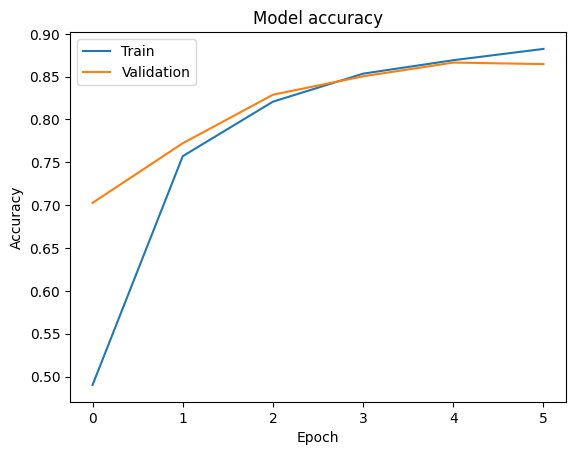

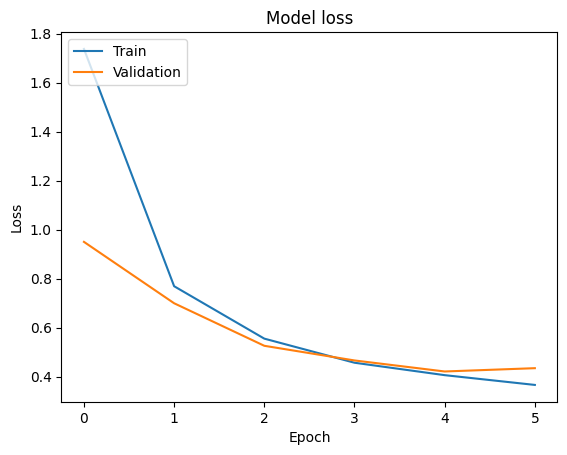

In [ ]:
# Plot training & validation accuracy values
!pip install matplotlib

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

****

**Confusion matrix and Classification report**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Get predictions and true labels
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

# Classification report
class_labels = list(validation_generator.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

439/439 ━━━━━━━━━━━━━━━━━━━━ 179s 407ms/step
[[ 9 16  5 ...  6 15 13]
 [10  9 11 ... 16 17 10]
 [ 7 12  7 ... 11 15 10]
 ...
 [14  5 11 ... 14 12 10]
 [ 7 16 11 ...  8  6  3]
 [ 4 11  8 ... 11  8 16]]
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.02      0.02      0.02       403
                                 Apple___Black_rot       0.02      0.02      0.02       397
                          Apple___Cedar_apple_rust       0.02      0.02      0.02       352
                                   Apple___healthy       0.03      0.03      0.03       401
                               Blueberry___healthy       0.03      0.04      0.03       363
          Cherry_(including_sour)___Powdery_mildew       0.03      0.03      0.03       336
                 Cherry_(including_sour)___healthy       0.01      0.01      0.01       365
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.03 

**Save the model**

In [ ]:
# Save the complete model for future use
model.save('Plantdiseases_model.h5')

# Save the class labels (indices to class mapping)
import json

class_indices = train_generator.class_indices
class_indices_inverted = {v: k for k, v in class_indices.items()}

with open('class_labels.json', 'w') as json_file:
    json.dump(class_indices_inverted, json_file)

**Model prediction**

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the pixel values
    return img_array

# Example prediction
img_path = '/content/dataset/preprocessed/valid/Apple___healthy/01b32971-5125-4982-98e2-22daa9ae864a___RS_HL 7977.JPG'  # Replace with your test image path
preprocessed_img = preprocess_image(img_path)
predictions = model.predict(preprocessed_img)

# Map the prediction index to the class
predicted_class = np.argmax(predictions[0])
class_label = class_indices_inverted[predicted_class]

# Print the class label and appropriate message based on the prediction
if "healthy" in class_label.lower():
    print(f"Predicted class: {class_label} - This plant is healthy.")
else:
    print(f"Predicted class: {class_label} - This plant contains some disease.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted class: Apple___healthy - This plant is healthy.


**Save to Google Drive**

In [ ]:
model.save('/content/drive/MyDrive/Plantdiseases_model.h5')

In [ ]:
model.save('/content/drive/MyDrive/model_weights.weights.h5')


In [ ]:
# ipython-input-18-e2744dbaf9b7
import json

# Assuming class_indices_inverted is already defined
# (from a previous cell where you created it)

with open('/content/drive/MyDrive/class_labels.json', 'w') as json_file:
    json.dump(class_indices_inverted, json_file)